In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Plot price data to check data read

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(gold['Gold'], marker='', label='Gold')
plt.plot(us['US'], marker='', label='USA')
plt.plot(europe['Europe'], marker='', label='Europe')
plt.plot(apac_x_japan['APACxJapan'], marker='', label='APAC ex. Japan')
plt.plot(japan['Japan'], marker='', label='Japan')
plt.plot(latam['LatAm'], marker='', label='LatAm')
plt.plot(us['US'], marker='', label='USA')



# Customize the plot
plt.title("Close Price by Exchange Date", fontsize=16)
plt.xlabel("Exchange Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

KeyError: 'Gold'

<Figure size 1000x600 with 0 Axes>

In [6]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [7]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


In [8]:
weights = {
    'Japan': 1/15,
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
    'Gold': 1/3,
}

# Calculate the portfolio return for each day
portfolio_return = (returns[list(weights.keys())] * list(weights.values())).sum(axis=1)

# Calculate cumulative return
cumulative_return = (1 + portfolio_return).cumprod() - 1

# Calculate annualized return
annualized_return = (1 + cumulative_return.iloc[-1]) ** (252 / len(portfolio_return)) - 1

# Calculate annualized volatility (standard deviation of returns)
annualized_volatility = portfolio_return.std() * (252 ** 0.5)

# Sharpe ratio (assuming risk-free rate of 0%)
sharpe_ratio = annualized_return / annualized_volatility

# Print results
print(f"Annualized Return: {annualized_return}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")

Annualized Return: 0.055218085911388215
Annualized Volatility: 0.10236539432329209
Sharpe Ratio: 0.5394214155713359


In [9]:
portfolio_return

Exchange Date
2005-01-31   -0.000471
2005-02-01    0.000284
2005-02-02    0.002359
2005-02-03   -0.005577
2005-02-04    0.004369
                ...   
2024-12-09    0.002258
2024-12-10    0.001169
2024-12-11    0.003793
2024-12-12   -0.010996
2024-12-13   -0.007764
Length: 5003, dtype: float64

In [10]:
cumulative_return

Exchange Date
2005-01-31   -0.000471
2005-02-01   -0.000187
2005-02-02    0.002172
2005-02-03   -0.003417
2005-02-04    0.000937
                ...   
2024-12-09    1.947495
2024-12-10    1.950940
2024-12-11    1.962132
2024-12-12    1.929560
2024-12-13    1.906814
Length: 5003, dtype: float64

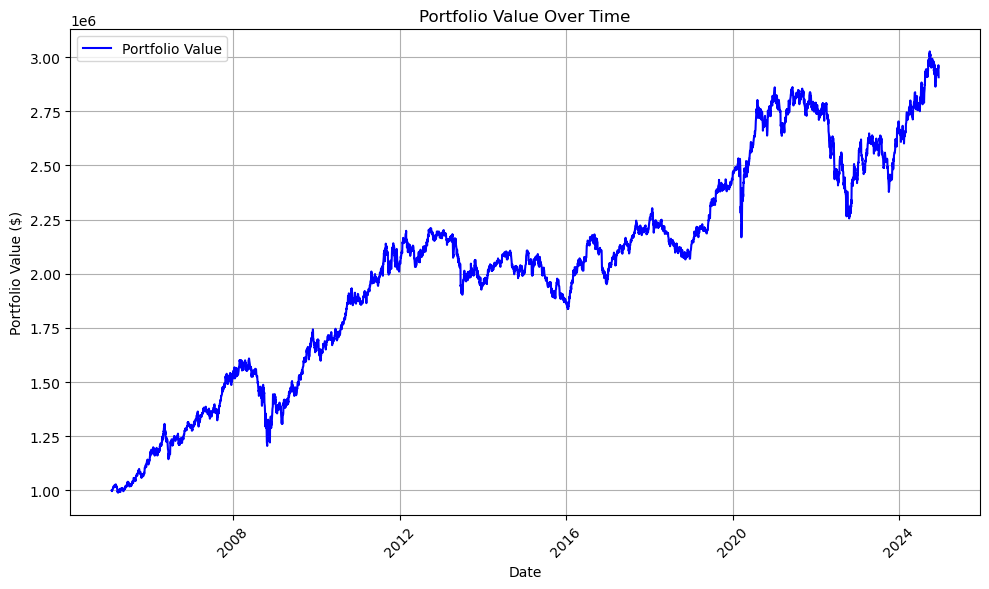

Final Portfolio Value: $2,906,814.33


In [15]:
# Initial investment
initial_investment = 1000000  # 1 million

# Calculate portfolio value over time
portfolio_value = initial_investment * (1 + cumulative_return)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Final Portfolio Value: ${portfolio_value.iloc[-1]:,.2f}")

In [16]:
portfolio_value

Exchange Date
2005-01-31    9.995292e+05
2005-02-01    9.998134e+05
2005-02-02    1.002172e+06
2005-02-03    9.965831e+05
2005-02-04    1.000937e+06
                  ...     
2024-12-09    2.947495e+06
2024-12-10    2.950940e+06
2024-12-11    2.962132e+06
2024-12-12    2.929560e+06
2024-12-13    2.906814e+06
Length: 5003, dtype: float64

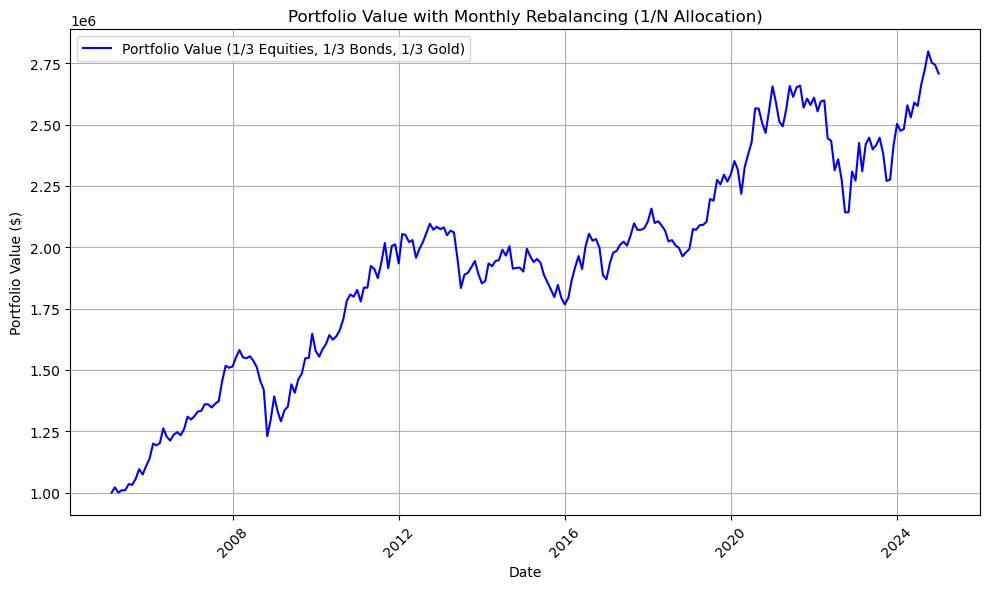

Final Portfolio Value: $2,707,952.79


In [20]:
equity_columns = ['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']
bond_columns = ['T-Bills_7_10', 'T-Bills_20']
gold_columns = ['Gold']

# Weights for equities and bonds
equity_weight = 1/3
bond_weight = 1/3
gold_weight = 1/3

# Resample the returns dataframe to monthly by calculating the cumulative returns for each month
# Resample to monthly frequency, taking the cumulative product of daily returns for each month
monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Calculate monthly equity and bond returns
monthly_equity_returns = monthly_returns[equity_columns].mean(axis=1)  # Average of equity returns for the month
monthly_bond_returns = monthly_returns[bond_columns].mean(axis=1)  # Average of bond returns for the month
monthly_gold_returns = monthly_returns[gold_columns].mean(axis=1)  # Average of bond returns for the month

# Initialize the portfolio with 1 million
initial_investment = 1_000_000
portfolio_value = pd.Series(index=monthly_returns.index)

# Set the initial portfolio value to 1 million
portfolio_value.iloc[0] = initial_investment

# Portfolio rebalancing loop for monthly rebalancing
for i in range(1, len(monthly_returns)):
    # Calculate the portfolio return for the current month (60% equity, 40% bond)
    portfolio_return = (
        (equity_weight * monthly_equity_returns.iloc[i]) + 
        (bond_weight * monthly_bond_returns.iloc[i]) + 
        (gold_weight * monthly_gold_returns.iloc[i])
        )
    
    # Get the portfolio value at the previous month
    prev_value = portfolio_value.iloc[i - 1]
    
    # Calculate the new portfolio value after returns for the month
    new_value = prev_value * (1 + portfolio_return)
    
    # Rebalance the portfolio to 60/40 (equity/bond) at the end of the month
    # We split the new value into equities and bonds
    equity_value = new_value * equity_weight
    bond_value = new_value * bond_weight
    gold_value = new_value * gold_weight
    
    # Set the new portfolio value for the current month
    portfolio_value.iloc[i] = equity_value + bond_value + gold_value

# Plot the portfolio value with monthly rebalancing
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Portfolio Value (1/3 Equities, 1/3 Bonds, 1/3 Gold)', color='blue')
plt.title('Portfolio Value with Monthly Rebalancing (1/N Allocation)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the final portfolio value
print(f"Final Portfolio Value: ${portfolio_value.iloc[-1]:,.2f}")

In [21]:
portfolio_returns = portfolio_value.pct_change().dropna()
portfolio_returns

Exchange Date
2005-02-28    0.021886
2005-03-31   -0.021253
2005-04-30    0.009511
2005-05-31   -0.000095
2005-06-30    0.025185
                ...   
2024-08-31    0.022737
2024-09-30    0.027209
2024-10-31   -0.016249
2024-11-30   -0.003525
2024-12-31   -0.012877
Freq: M, Length: 239, dtype: float64

In [22]:
rolling_annual_volatility = portfolio_returns.rolling(window=12).std() * np.sqrt(12)
rolling_annual_volatility

Exchange Date
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31         NaN
2005-06-30         NaN
                ...   
2024-08-31    0.103832
2024-09-30    0.082659
2024-10-31    0.088353
2024-11-30    0.075587
2024-12-31    0.073235
Freq: M, Length: 239, dtype: float64

In [53]:
print(f"Average annualized monthly volatility: {rolling_annual_volatility.mean()}")
total_return = (portfolio_value.iloc[-1]-portfolio_value.iloc[0])/portfolio_value.iloc[0]
print(f"Total return: {total_return*100}%")
monthly_returns = portfolio_returns
avg_monthly_return = monthly_returns.mean()
print(f"Average monthly return: {avg_monthly_return}")
print(f"Average yearly return: {((1+avg_monthly_return)**12)-1}")
print(f"Sharpe Ratio: {(((1+avg_monthly_return)**12)-1)/rolling_annual_volatility.mean()}")

Average annualized monthly volatility: 0.09472933923902105
Total return: 170.79527894231558%
Average monthly return: 0.0045818942350443455
Average yearly return: 0.056389700465308445
Sharpe Ratio: 0.5952717597134924


In [54]:
# Calculate the monthly VaR for each month using the Historical Simulation method
VaR_99 = portfolio_returns.quantile(1 - 0.99)

# Print the Value at Risk
print(f"Monthly 99% Value at Risk (VaR) is: {VaR_99:.4f}")

Monthly 99% Value at Risk (VaR) is: -0.0592
